#### U-Net
1. U-Net은 biomedical 분야에서 이미지 분할 (Image Segmentation)을 목적으로 제안된 End-to-End 방식의 Fully-Connected Network기반의 model이다.
2. 네트워크의 모양이 'U'자 모양을 띈다고 해서 U-Net이라고 이름이 붙여진 것이다.
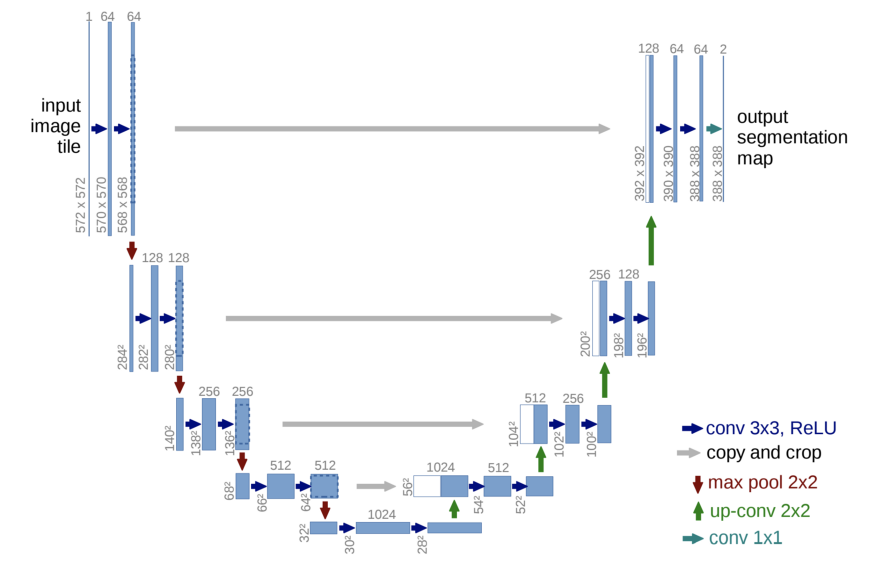


### 1. Contracting Path (수축 경로)
#### 1. 3x3 Convolution
1. 해당 작업은 2번 연속으로 진행한다.
2. 이를 논문에서는 multi-channel feature map으로 명명한다.
3. 각 contracting step마다 3x3 convolution을 2번씩 진행한다. 
  - 이때 padding(크기가 감소하면 빈자리를 0이나 1로 채워주는 과정) 이 없기 떄문에 특징 벡터의 크기가 점점 감소한다. 
  - 역시나 convolution에는 ReLU활성화 함수가 사용이 된다.

#### 2. 2x2 Max Pooling
1. pooling layer의 역할이 일반적으로 이미지 데이터의 크기를 줄이는데에 있음을 기억해보자.
2. 즉, downsampling을 위치정보를 잃지 않는 선에서 진행을 하는 것이다.
3. Feature Map의 크기를 절반으로 줄여준다.
4. Max Pooling layer을 이용해서 downsampling을 진행할 때마다 채널의 수가 2배로 늘어나게 된다.

큰 patch size는 더 많은 개수의 max-pooling layer을 요구하는 반면, 작은 patch size는 더 적은 개수를 필요로 하는 대신에 네트워크가 이미지를 볼 때에 적은 크기의 면적만의 특징을 고려할 수 밖에 없다.  

따라서 고안된 network가 Fully Connected Network, 즉 FCN이고 이 구조를 이용해서 U-Net가 만들어진 것이라고 할 수 있다.

Main idea is to supplement a usual contracting network by successive layers, where pooling operators are replaced by upsampling operators.

In [ ]:
import torch
import torch.nn
import torch.nn.Functional as F

In [ ]:
class Conv(nn.Module):
  def __init__(self, inchannel, outchannel, midchannel = None):
    # 구조를 보게 되면 두번째 채널의 크기와 마지막 채널의 크기가 동일하다.
    # 따라서 None으로 입력 받으면 outchannel의 값과 같도록 한다.
    # 객체 지향 프로그래밍의 이해또한 여기서 필요한데, Conv라는 생성자에 들어간 __init__와 forward함수는 반드시 nn.Module을 이용해서 layer을 만들고자 할 떄 들어가야 한다.
    super().__init__()
    self.inchannel = inchannel
    self.outchannel = outchannel
    if not midchannel:
      midchannel = outchannel
    self.DoubleConv = nn.Sequential(
        nn.Conv2d(inchannel, midchannel, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(midchannel),
        nn.Relu(inplace = True),
        nn.Conv2d(midchannel, outchannel, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(midchannel),
        nn.Relu(inplace = True)
    )

    def forward(self, x):
      return self.Conv(x)

In [ ]:
class Down(nn.Module):
  def __init__(self, inchannel, outchannel):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(inchannel, outchannel)
    )

### 2. Expansion Path(확장 경로)
#### 1. 3x3 Conv
- Relu 활성화 함수를 사용

#### 2. 2x2 Conv
- up-convolution을 진행할 수 있게 도와주는 역할을 한다.
- 이번에는 feature map의 크기를 2배로 늘리는 역할을 한다.
- 대신 channel의 수는 매번 절반으로 줄어드는 과정을 거친다.

#### 3. 1x1 Conv
- 마지막의 출력층에서 class값을 예측하기 위해서 1x1 convolution layer을 사용한다.
- 즉, 비선형성을 부여하는 것이다. 
- 예측하고자하는 class의 개수와 일치하는 가중치를 가질 수 있도록 한다.

**각 expanding path마다 up-convolution된 특징맵은 contracting path, 즉 이전의 수축 단계에서 추출한 feature map의 테두리를 crop하는 과정을 진행한 것을 현재 expansion path의 convolution layer의 feature map과 concatenation을 진행해서 사용한다.**



In [ ]:
class Up(nn.module):
  def __init__(self, inChannel, outChannel, bilinear = True):
    super.__init__()

    if bilinear:
      self.up = nn.UpSample(scale_factor = 2, mode = 'bilinear', align_corners = True)
      self.conv = DoubleConv(inChannel, outChannel, inChannel/2)
    else:
      self.up = nn.ConvTranspose2d(inChannel, inChannel/2, kernel_size = 2, stride = 2)
      self.conv = DoubleConv(inChannel, outChannel)
    
  def forward(self, x1, x2):
    x1 = self.up(x1)
    Y = x2.size()[2] - x1.size()[2]
    X = x2.size()[3] - x1.size()[3]

    x1 = F.pad(x1, [X//2, X-X//2, Y//2, Y-Y//2])
    x = torch.cat([x2, x1], dim = 1)
    return self.conv(x)

In [ ]:
class OutConv(nn.module):
  def __init__(self, inChannel, outChannel):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(inChannel, outChannel, kernel_size = 1) #1x1 Conv
  
  def forward(self, x):
    return self.conv(x)
  

### 3. Full Network

In [ ]:
class UNet(nn.Module):
  def __init__(self, n_channels, n_classes, bilinear = True):
    super(UNet, self)._init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.bilinear = bilinear

    self.inc = DoubleConv(n_channels, 64)
    self.Down1 = Down(64, 128)
    self.Down2 = Down(128, 256)
    self.Down3 = Down(256, 512)
    factor = 2 if bilinear else 1
    self.Down4 = Down(512, 1024 // factor)
    self.Up1 = Up(1024, 512//factor, bilinear)
    self.Up2 = Up(512, 256//factor, bilinear)
    self.Up3 = Up(256, 128//factor, bilinear)
    self.Up4 = Up(128, 64, bilinear)
    self.outc = OutConv(64, n_classes)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.Down1(x1)
    x3 = self.Down2(x2)
    x4 = self.Down3(x3)
    x5 = self.Down4(x4)
    # upsampling step을 진행하기 위해서는 이전 downsampling step에서 추출한 특징 맵을 crop해서 사용해야 한다.
    x = self.Up1(x5, x4)
    x = self.Up2(x, x3)
    x = self.Up3(x, x2)
    x = self.Up4(x,x1)
    x = self.outc(x)
    return x
